In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
url = 'https://www.nseindia.com/api/option-chain-indices?symbol=NIFTY'

In [3]:
headers = {
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.99 Safari/537.36',
    'accept-encoding': 'gzip, deflate, br' ,
    'accept-language': 'en-US,en;q=0.9'
    
}

In [4]:
session = requests.Session()
request = session.get(url, headers=headers)
cookies = dict(request.cookies)
response = session.get(url, headers=headers, cookies=cookies).json()
rawdata = pd.DataFrame(response)

In [5]:
df= pd.DataFrame(response["records"]['data']).fillna(0)

In [6]:
def option_dataframe(df):
    data = []
    df.sort_values(by=["expiryDate", "strikePrice"], ascending=True, inplace=True)
    for i in range(len(df)):
        call_oi = call_coi = put_oi = put_coi  = int(0)
        call_IV = put_IV = call_ltp = put_ltp = float(0)
        strike = df.iloc[i,0]
        expiry = df.iloc[i,1]
        if(df.iloc[i,-1] == 0):
            calloi = call_coi = 0
        else:
            call_oi = df.iloc[i,-1]["openInterest"]
            call_coi = df.iloc[i,-1]["changeinOpenInterest"]
            call_ltp = df.iloc[i,-1]['lastPrice']
            call_IV = df.iloc[i,-1]['impliedVolatility']
        
        if(df.iloc[i,-2] == 0):
            putoi = put_coi = 0
        else:
            put_oi = df.iloc[i,-2]["openInterest"]
            put_coi = df.iloc[i,-2]["changeinOpenInterest"]
            put_ltp = df.iloc[i,-2]['lastPrice']
            put_IV = df.iloc[i,-2]['impliedVolatility']
            
        option_data = {"Expiry": expiry,
            "Call OI" : call_oi, "Call C_OI" : call_coi,"Call IV": call_IV ,"Call LTP" : call_ltp, "STRIKE" : strike,
             "Put LTP" : put_ltp ,"Put IV" : put_IV , "Put C_OI" : put_coi, "Put OI" : put_oi
        }
        data.append(option_data)
    optionchain = pd.DataFrame(data)

    return optionchain , df.iloc[0,-1]["underlyingValue"]

In [7]:
optionchain  , underlying_ltp = option_dataframe(df) 

In [8]:
strike_list = pd.Series(optionchain["STRIKE"].unique()).sort_values(ascending=True)
expiries_list = pd.to_datetime(optionchain["Expiry"].unique()).sort_values(ascending=True)

In [9]:
optionchain

,Expiry,Call OI,Call C_OI,Call IV,Call LTP,STRIKE,Put LTP,Put IV,Put C_OI,Put OI
0,03-Feb-2022,14.0,13.0,102.59,2216.60,15100,2.75,41.92,9824,59036.0
1,03-Feb-2022,0.0,0.0,0.00,0.00,15150,3.05,41.49,246,246.0
2,03-Feb-2022,0.0,0.0,0.00,0.00,15200,3.00,40.43,4689,10034.0
3,03-Feb-2022,0.0,0.0,0.00,0.00,15250,3.30,39.94,346,346.0
4,03-Feb-2022,0.0,0.0,0.00,0.00,15300,3.45,39.19,6803,14499.0
...,...,...,...,...,...,...,...,...,...,...
1004,31-Mar-2022,13.0,3.0,19.88,39.00,19750,0.00,0.00,0,0.0
1005,31-Mar-2022,0.0,0.0,0.00,0.00,19800,0.00,0.00,0,0.0
1006,31-Mar-2022,9713.0,302.0,19.57,25.10,20000,2537.60,0.00,14,1431.0
1007,31-Mar-2022,2623.0,23.0,20.98,17.75,20500,3041.50,0.00,17,141.0


In [10]:
def by_expiry(optionchain, cutoff = 50):
    option_dict = {}
    optionchain["Expiry"] = pd.to_datetime(optionchain["Expiry"])
    for i in  range(len(expiries_list)):
        option_dict[i] = optionchain.loc[optionchain["Expiry"] == expiries_list[i]]
        option_dict[i] = option_dict[i].drop(option_dict[i][(option_dict[i]["Call OI"]<=cutoff) | (option_dict[i]["Put OI"]<=cutoff)].index)
        option_dict[i].reset_index(inplace=True,drop=True)
        option_dict[i].drop(["Expiry"], axis=1, inplace=True)
    return option_dict

In [11]:
def by_strike(optionchain, cutoff = 50):
    optionchain.sort_values(by=["STRIKE","Expiry"], inplace=True, ascending=True)
    option_dict = {}
    for i in  strike_list:
        option_dict[i] = optionchain.loc[optionchain["STRIKE"] == i]
        option_dict[i] = option_dict[i].drop(option_dict[i][(option_dict[i]["Call OI"]<=cutoff) | (option_dict[i]["Put OI"]<=cutoff)].index)
        option_dict[i] = option_dict[i].drop(option_dict[i][(option_dict[i]["Call LTP"] == 0) | (option_dict[i]["Put LTP"] == 0)].index)
        option_dict[i].reset_index(inplace=True,drop=True)
        option_dict[i].drop(["STRIKE"], axis=1, inplace=True)
    return option_dict

In [12]:
expiry = by_expiry(optionchain, cutoff = 100)
strike = by_strike(optionchain, cutoff = 100)

In [15]:
expiry[0]

,Call OI,Call C_OI,Call IV,Call LTP,STRIKE,Put LTP,Put IV,Put C_OI,Put OI
0,362.0,9.0,86.88,1810.00,15500,4.50,36.56,23174,48115.0
1,1517.0,-392.0,77.00,1364.65,16000,9.60,29.96,11243,39842.0
2,103.0,46.0,66.29,1073.90,16300,17.75,26.38,7051,14713.0
3,1278.0,-5.0,63.93,1021.70,16350,19.90,25.81,1128,2152.0
4,1833.0,208.0,58.84,880.70,16500,29.00,24.26,16980,45729.0
5,715.0,-126.0,55.38,787.40,16600,37.50,23.22,5061,25264.0
6,148.0,-12.0,52.11,729.05,16650,42.70,22.69,2516,3522.0
7,713.0,-134.0,52.49,700.00,16700,48.80,22.19,27482,34368.0
8,164.0,-14.0,51.99,664.60,16750,56.00,21.71,2238,3259.0
9,1584.0,-26.0,49.89,616.75,16800,64.00,21.20,15571,26078.0


In [16]:
strike[17100]

,Expiry,Call OI,Call C_OI,Call IV,Call LTP,Put LTP,Put IV,Put C_OI,Put OI
0,2022-02-03,20114.0,5166.0,43.16,392.40,138.80,17.55,9585,22954.0
1,2022-02-10,899.0,-36.0,33.84,466.90,203.75,18.19,541,1213.0
2,2022-02-24,6257.0,-133.0,25.33,534.90,267.80,17.73,1583,13006.0
3,2022-03-31,211.0,53.0,20.08,716.55,382.45,18.46,282,951.0


In [13]:
def plot_graph_expiry(options, expiry=0):
    plt.plot(options[expiry]["STRIKE"],options[expiry]["Call IV"])
    plt.plot(options[expiry]["STRIKE"],options[expiry]["Put IV"], color='r')#, figure=(20,16)
    plt.grid('True')
    plt.title("Option Skew")
    plt.xlabel("Strikes")
    plt.legend(["Call Skew","Put Skew"])
    plt.ylabel("Implied Volatility")
    plt.axvline(x=underlying_ltp, color = 'r', linestyle = '--')
    plt.show();

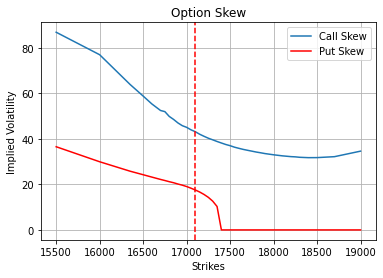

In [53]:
plot_graph(expiry, 0)

In [54]:
strike_list

107     7500
136     8300
108     8500
109     8700
110     9000
       ...  
99     20000
135    20500
100    21000
101    22000
102    23000
Length: 140, dtype: int64